<a href="https://colab.research.google.com/github/marcusnk237/Binary-Classification-Cough-COVID/blob/main/Binary_classification_cough_COVID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries


In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import csv
import itertools
from imblearn.over_sampling import SMOTE
from collections import Counter
import librosa


# Processing functions

## This function allows us to get negative and positive patients data path

In [2]:
def prep_organize_data(POS_PATH, NEG_PATH, BASE_PATH): 

    #our data :-> Positive 
    pos_files = os.listdir(POS_PATH)
    base_path_pos = BASE_PATH + 'positive/'
    pos_data = [base_path_pos+x for x in pos_files]

    #our data :-> Negative
    neg_files = os.listdir(NEG_PATH)
    base_path_neg = BASE_PATH + 'negative/'
    neg_data = [base_path_neg+x for x in neg_files]

    #number of samples 
    tot_samples = len(neg_data) + len(pos_data)

    #fraction of samples 
    frac_pos = ((len(pos_data) / tot_samples)*100)
    frac_neg = ((len(neg_data) / tot_samples)*100)
    

    print(f"Number of Negative samples: {len(neg_data)} ({frac_neg:.2f}%)")
    print(f"Number of Positive samples: {len(pos_data)} ({frac_pos:.2f}%)\n")
    print(f"**** Total samples: {tot_samples} ****")
    
    return pos_files, pos_data, neg_files, neg_data

## This function allows us to know the data repartition inside the dataset

In [3]:
def class_repartitions (y):
  counter = Counter(y)
  for k,v in counter.items():
	    per = v / len(y) * 100
	    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
  # plot the distribution
  plt.bar(counter.keys(), counter.values())
  plt.show()

## This function allows us to extract the features of each signal. It's those we'll use for the classification

In [4]:
def get_dataframe(dir_path='data'):
    '''
    Function which writes data to csv.
    Features it uses: 
    - RMSE 
    - Chroma STFT
    - Spectral Centroid
    - Spectral Bandwidth 
    - Spectral Rolloff 
    - Zero Crossing 
    Input: files in directory, 
    '''
    columns=['chroma_stft', 'rmse', 'spectral_centroid' ,'spectral_bandwidth', 'rolloff', 'zero_crossing_rate' ]
    for x in range(1,21):
        columns.append('mfcc'+str(x))
    columns.append('label')
    datas=[]
    results = ['negative','positive']
    for res in results: 
        for files in os.listdir(f"{dir_path}/{res}"):
            data=[]
            x, sr = librosa.load(f"{dir_path}/{res}/{files}", mono=True)
            data.append(np.mean(librosa.feature.chroma_stft(y=x, sr=sr)))            
            data.append(np.mean(librosa.feature.rms(y=x)))
            data.append(np.mean(librosa.feature.spectral_centroid(y=x, sr=sr)))
            data.append(np.mean(librosa.feature.spectral_bandwidth(y=x, sr=sr)))
            data.append(np.mean(librosa.feature.spectral_rolloff(y=x, sr=sr)))
            data.append(np.mean(librosa.feature.zero_crossing_rate(x)))
            mfcc = librosa.feature.mfcc(y=x, sr=sr)
            for k in mfcc:
                data.append(np.mean(k))
            data.append(results.index(res))
            datas.append(data)
            #print(data)
    return pd.DataFrame(datas, columns=columns)

## These functions allows us to evaluate a Neural Network model

In [5]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalize confusion matrix")
    else:
        print('Confusion matrix')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Class')
    plt.xlabel('Predicted Class')

In [6]:
def evaluate_model(history,X_test,y_test,model):
    #################### Evaluation  #########################
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Précision: %.2f%%" % (scores[1]*100))
    ##########################################################
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()

    prediction_proba=model.predict(X_test) # Get a prediction
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_test, prediction) # Compute the confusion matrix
    plot_confusion_matrix(cnf_matrix,['Negative','Positive'],True) # Plot the confusion matrix
    print(classification_report(y_test, prediction)) #Print classification report

## This function allows us to compute, compile and train an Artifical Neural Network for the cough classification

In [7]:
def ann_model(X_train,y_train,X_test,y_test):
  model_1 = models.Sequential()
  model_1.add(layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
  #model_1.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
  #model_1.add(layers.Dense(128, activation='relu'))
  #model_1.add(layers.Dense(1024, activation='relu'))
  #model_1.add(layers.Dense(512, activation='relu'))
  #model_1.add(layers.Dense(64, activation='relu'))
  #model_1.add(layers.Dense(10, activation='relu')
  model_1.add(layers.Dense(256, activation='relu'))
  model_1.add(layers.Dense(128, activation='relu'))
  model_1.add(layers.Dense(64, activation='relu'))
  model_1.add(layers.Dense(27, activation='relu'))
  model_1.add(layers.Dense(2, activation='softmax'))
  #compiling
  model_1.compile(optimizer='adam', 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])
  model_1.summary()
  #fitting
  history = model_1.fit(X_train, y_train, epochs=30, batch_size=50, validation_data=(X_test, y_test))
  
  #evaluating
  return evaluate_model(history,X_test,y_test,model_1)

## This function allows us to compute, compile and train a Convolutionnal Neural Network for the cough classification

In [8]:
def cnn_model(X_train,y_train,X_test,y_test):
  im_shape=(X_train.shape[1],1)
  inputs_cnn=layers.Input(shape=(im_shape), name='inputs_cnn')
  conv1_1= layers.Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
  conv1_1=layers.BatchNormalization()(conv1_1)
  pool1=layers.MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
  conv2_1=layers.Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
  conv2_1=layers.BatchNormalization()(conv2_1)
  pool2=layers.MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
  conv3_1=layers.Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
  conv3_1=layers.BatchNormalization()(conv3_1)
  pool3=layers.MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
  flatten=layers.Flatten()(pool3)
  dense_end1 = layers.Dense(64, activation='relu')(flatten)
  dense_end2 = layers.Dense(27, activation='relu')(dense_end1)
  main_output = layers.Dense(2, activation='softmax', name='main_output')(dense_end2)
  model = models.Model(inputs= inputs_cnn, outputs=main_output)
  #compiling 
  model.compile(optimizer='adam', 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])
  model.summary()
  #fitting
  history = model.fit(X_train, y_train, epochs=30, batch_size=50, validation_data=(X_test, y_test))
  #evaluating
  return evaluate_model(history,X_test,y_test,model)

# Main Program

## Downloading the dataset
We've uploaded the Coswada Dataset to our Kaggle account. To retrieve the dataset, we need :
* To download the kaggle librarie 
* Load our account's toke API
* And then, download the dataset, thanks to a specific command

### Downloading kaggle librarie and load the token API

In [9]:
! pip install -q kaggle
########################

### Select kaggle.json file ##
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"marcjuniornkengue","key":"5414caa09551f347f107ca24749878af"}'}

In [10]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


### Downloading  and unzipping the dataset

In [11]:
!kaggle datasets download -d marcjuniornkengue/coswara-dataset

 91% 121M/133M [00:03<00:00, 37.1MB/s]
100% 133M/133M [00:03<00:00, 37.1MB/s]


In [12]:
!unzip \*.zip  && rm *.zip

Archive:  coswara-dataset.zip
  inflating: data/negative/1_Negativo_34_f_17-6-20_1.wav  
  inflating: data/negative/1_Negativo_34_f_17-6-20_2.wav  
  inflating: data/negative/1_Negativo_34_f_18-6-20_1.wav  
  inflating: data/negative/1_Negativo_34_f_18-6-20_2.wav  
  inflating: data/negative/1_Negativo_34_f_19-6-20_1.wav  
  inflating: data/negative/1_Negativo_34_f_19-6-20_2.wav  
  inflating: data/negative/1_Negativo_34_f_21-6-20_1.wav  
  inflating: data/negative/1_Negativo_34_f_21-6-20_2.wav  
  inflating: data/negative/1_Negativo_34_f_22-6-20_1.wav  
  inflating: data/negative/1_Negativo_34_f_22-6-20_2.wav  
  inflating: data/negative/22_Negativo_22_m_17-6-20_1.wav  
  inflating: data/negative/22_Negativo_22_m_19-6-20_1.wav  
  inflating: data/negative/22_Negativo_22_m_19-6-20_2.wav  
  inflating: data/negative/22_Negativo_22_m_21-6-20_1.wav  
  inflating: data/negative/22_Negativo_22_m_21-6-20_2.wav  
  inflating: data/negative/34_Negativo_27_f_17-6-20_1.wav  
  inflating: data/ne

## Load datas and get it as a dataframe

In [13]:
# Files path
POS_PATH = r"data/positive"
NEG_PATH = r"data/negative"
BASE_PATH = r"/data/"

In [14]:
# Getting files by labels
pos_files, pos_data, neg_files, neg_data = prep_organize_data(POS_PATH, NEG_PATH, BASE_PATH)

Number of Negative samples: 37 (7.91%)
Number of Positive samples: 431 (92.09%)

**** Total samples: 468 ****


In [15]:
#columns for dataframe
cols = ["ID", "Result", "Age", "Gender", "Date", "Extra"]

#creating the dataframe
neg = pd.DataFrame([x.split("_") for x in neg_files])
pos = pd.DataFrame([x.split("_") for x in pos_files])

#joining and cleaning of datatypes
df = neg.append(pos)
df.columns = cols
df.drop(["Extra", "Date"],axis=1, inplace=True)
df['ID'] = df['ID'].astype('int')
df['Age'] = df['Age'].astype('int')

## Extract features of each signal and concatenate each result, to form a dataframe

In [16]:
#Getting features dataframe
dataframe=get_dataframe()
dataframe

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.469563,0.027699,2068.639170,2084.659340,4524.942753,0.112125,-326.110779,112.680634,-18.334488,23.394382,-30.999292,4.721496,-18.844225,4.023946,-16.595779,6.471510,-6.586917,5.293828,-2.487664,-10.684472,-2.956739,-6.756854,-6.272454,-2.941332,-6.438285,-5.223113,0
1,0.465861,0.050972,2316.111721,2326.976353,5347.386475,0.121767,-358.203613,72.316124,15.508433,9.371363,-5.771358,10.754352,-8.273645,-6.707999,-10.333981,1.196330,-1.491788,-7.276796,-0.357680,4.126705,2.220901,1.387475,-1.121793,-0.618045,-3.763079,-2.179579,0
2,0.438940,0.034090,2716.312872,2234.330967,5386.474095,0.180564,-377.770233,60.139278,-15.199933,16.248096,-17.796728,20.652931,-6.811646,-2.891916,-10.236591,1.043826,-5.127304,-6.896268,-7.519525,-0.309051,-10.031704,1.064903,-5.766325,-9.738605,-0.735506,-4.453575,0
3,0.440035,0.047846,2091.901208,2115.759222,4647.938220,0.127258,-293.405182,103.014771,-1.954980,31.585417,-21.440050,14.288349,-17.899891,-3.527612,-8.950913,-1.653934,-3.704292,-10.731703,0.270006,-5.631326,-5.660220,-9.104214,-7.143483,-1.097497,-7.347589,-2.173496,0
4,0.434661,0.051143,2020.050616,1968.242299,4061.023592,0.123378,-296.038788,102.051331,-10.046681,19.475552,-23.288652,12.344568,-6.339717,-1.067432,-15.595660,2.212250,-4.360793,-6.958616,-8.974069,-4.881073,-7.650972,-0.909539,-5.453292,-9.714471,-4.718580,-4.715248,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,0.457470,0.038365,1268.570031,1406.685250,2285.275269,0.071835,-306.855133,155.362900,-18.743719,7.184014,-20.070562,-5.849297,-17.078465,-1.662924,-19.230673,-1.096364,5.331760,-11.415610,-5.399570,-4.221684,-4.466081,-8.013326,-1.732868,-3.344301,-4.106666,-2.235071,1
464,0.347917,0.024379,1174.980541,1254.188009,2254.257202,0.059800,-349.128601,142.936859,-37.288521,24.560284,-31.824329,9.280874,-19.878143,-9.761832,-14.361849,-1.980968,-0.080041,-8.724832,-1.461505,-12.924691,4.267704,-10.513121,-4.919448,-9.737626,-3.179120,-4.562567,1
465,0.565149,0.012435,2012.213981,1942.603935,4119.893606,0.130568,-476.308929,113.009583,-14.827119,-6.716372,-23.794834,6.768663,-14.223404,0.724188,-2.462110,2.049082,-3.748639,-2.445319,-3.568883,-6.561741,-3.189724,-4.640841,-3.988842,-4.635415,-4.023716,-0.170226,1
466,0.354833,0.014103,1042.820841,1294.407323,1822.156292,0.052881,-415.937500,145.324081,7.895137,10.597734,-21.752254,-0.646302,-16.141907,-8.816514,-7.333563,-0.223555,2.464241,-0.890801,0.999515,-5.473987,5.680019,-5.207739,-3.072631,-4.064567,-2.402019,-1.274683,1


### Oversampling and Shuffle the dataframe

Class=0, n=37 (7.906%)
Class=1, n=431 (92.094%)


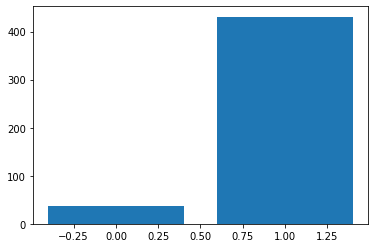

Class=0, n=431 (50.000%)
Class=1, n=431 (50.000%)


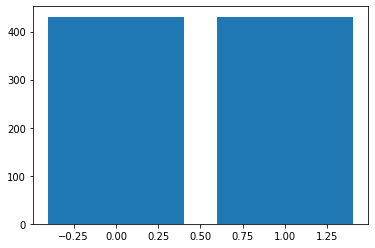

In [22]:
# We first oversampling the dataset and recreate a new one
X_0 = (dataframe.iloc[:, :-1])
Y_0 = dataframe[dataframe.columns[-1]]
label_encoder = LabelEncoder()
y0 = label_encoder.fit_transform(Y_0)
# Repartition before oversampling 
class_repartitions(y0)
oversample = SMOTE()
X0, y0 = oversample.fit_resample(X_0, Y_0)
data_new= np.column_stack((X0, y0))
df_new=pd.DataFrame(data_new)
# Repartition after oversampling 
class_repartitions(y0)

#since all the positives were first and negatives last, we shuffling the dataset
shuffle_df = df_new.reindex(np.random.permutation(df_new.index))
#labels
y = shuffle_df[shuffle_df.columns[-1]].to_numpy()
#rest of data
X = (shuffle_df.iloc[:, :-1]).to_numpy()

In [19]:
shuffle_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
661,0.470767,0.058401,2227.240125,2227.877643,4913.771605,0.119690,-360.122877,80.870543,6.826561,9.144420,-5.474337,5.414609,-10.143826,-5.070559,-8.969956,6.751004,-1.970497,-4.974191,2.840263,1.940707,-2.202229,1.195475,-2.062243,-3.689171,-3.916405,-2.418287,0.0
425,0.504881,0.064149,1509.589179,1844.627571,3252.074432,0.072805,-361.726654,104.306213,26.151779,12.139683,-17.585943,11.647525,-3.958611,-2.353428,-8.732712,-0.110933,4.464777,1.134828,-5.246283,-0.002844,0.002191,-0.445201,-1.184139,-3.642844,-5.841795,-3.360677,1.0
105,0.487653,0.032170,2689.742295,2024.303804,4867.114159,0.224406,-315.162628,76.240372,-32.773502,38.433380,-17.003874,3.001243,-11.413467,0.880050,-12.467845,2.768908,-9.401409,-10.172063,-5.251383,-7.311748,-1.835274,-5.487806,-4.813458,-1.175866,-4.218311,-1.710794,1.0
273,0.435621,0.049614,2300.485093,2190.916276,4877.920839,0.171790,-310.675323,96.414757,3.212909,28.301270,-24.986738,16.642647,-16.734257,-5.013194,-17.706491,5.001572,-1.998693,-12.059823,0.905726,0.100539,-5.850832,-1.839179,0.054656,-9.771989,-8.819985,1.758794,1.0
738,0.462679,0.033443,2127.177986,2096.087179,4495.348335,0.132410,-362.550982,103.038403,0.514348,23.693949,-25.655011,5.401483,-19.424800,-3.229294,-15.520549,0.783454,-1.768931,-8.333391,0.890163,-5.407592,-1.535580,-3.353889,-8.648714,-1.860161,-8.177231,-4.575151,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647,0.477130,0.041455,2529.049318,2426.705201,5686.839596,0.134719,-381.790720,70.199310,10.969486,16.567746,-9.283583,12.971568,-6.446541,2.528498,-10.943871,2.501640,-5.126988,-0.912797,-3.179977,-0.615337,-4.460165,-0.854298,-3.145844,-4.392532,-3.783595,-3.437740,0.0
83,0.511454,0.059657,1723.211371,1871.648265,3631.008044,0.087934,-359.589935,93.802696,8.373181,9.755779,-4.911791,12.550925,-6.827497,-1.086200,-7.787720,-3.194243,3.137789,-6.239973,-6.640262,-0.654889,-1.792025,1.140976,1.178445,0.311361,0.257728,-0.987110,1.0
586,0.435629,0.043588,2713.700094,2114.341570,5076.543401,0.195970,-323.790152,59.698810,-22.952138,19.910796,-23.130258,11.719758,-12.652413,-4.108982,-12.301020,-5.292514,0.264903,-5.039499,-6.889791,4.755282,-10.082084,-1.988501,0.087119,-8.299794,-2.454350,-1.835830,0.0
659,0.617034,0.027671,1828.718323,1893.310732,3764.072083,0.085508,-398.275467,79.904404,1.491583,31.203888,10.767023,7.488944,7.530208,6.297152,1.190712,12.570542,2.740138,-0.754397,4.169652,1.810624,-0.154062,-0.603705,-1.855148,-2.115644,-1.439436,1.661864,0.0


## Encoding data and split it into two datasets : train dataset and test dataset

In [23]:
#since all the positives were first and negatives last, we shuffling the dataset
#instantiate the Label Encoder
y = label_encoder.fit_transform(y)
#instantiate scaler 
scaler = StandardScaler()
#fit transform scaler 
X = scaler.fit_transform(X)

#separating the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               13824     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 27)                1755      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 56        
Total params: 188,115
Trainable params: 188,115
Non-trainable params: 0
__________________________________________________

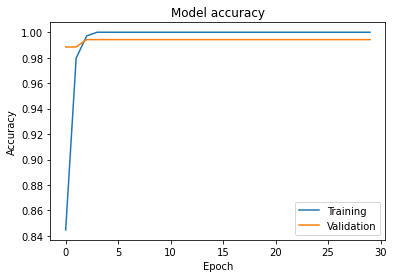

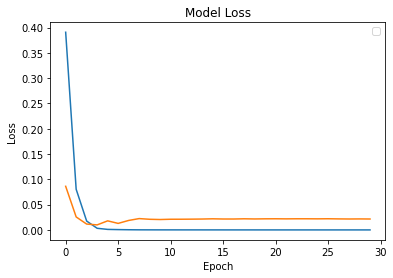

Normalize confusion matrix
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        90
           1       1.00      0.99      0.99        83

    accuracy                           0.99       173
   macro avg       0.99      0.99      0.99       173
weighted avg       0.99      0.99      0.99       173



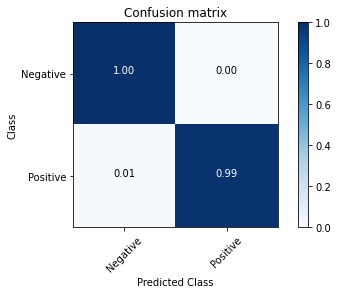

In [24]:
ann_model(X_train,y_train,X_test,y_test)

## Compute, compile, train and evaluate each model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs_cnn (InputLayer)      [(None, 26, 1)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 21, 64)            448       
_________________________________________________________________
batch_normalization (BatchNo (None, 21, 64)            256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 9, 64)             12352     
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 64)             256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 64)             0     

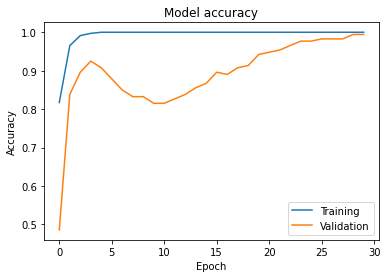

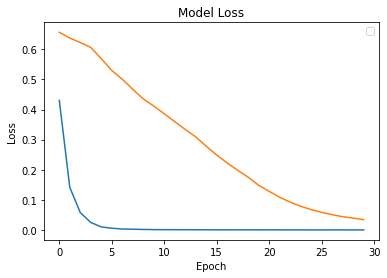

Normalize confusion matrix
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        90
           1       1.00      0.99      0.99        83

    accuracy                           0.99       173
   macro avg       0.99      0.99      0.99       173
weighted avg       0.99      0.99      0.99       173



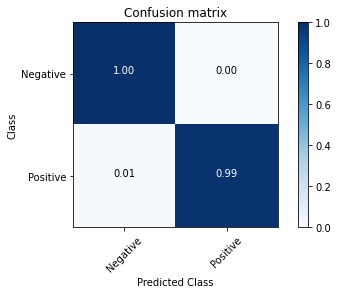

In [25]:
cnn_model(X_train,y_train,X_test,y_test)